In [1]:
import pandas as pd
import seaborn as sns
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute, roll_time_series
import numpy as np
import matplotlib.pyplot as plt


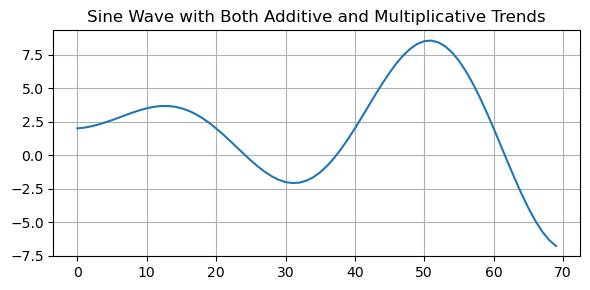

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for the sine wave and trends
n_points = 70
frequency = 0.025
amplitude = 1.0 / 4
x = np.arange(n_points)
additive_trend = 2 + 0 * x
multiplicative_trend = 1 + 0.5 * x

pure_sine_wave = amplitude * np.sin(2 * np.pi * frequency * x)
sine_wave_both_trends = (pure_sine_wave * multiplicative_trend) + additive_trend

signals = [sine_wave_both_trends]
labels = ["Sine Wave with Both Additive and Multiplicative Trends"]

# Plot the time series
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), squeeze=False)
for ax, signal, label in zip(axes.flatten(), signals, labels):
    ax.plot(signal)
    ax.set_title(label)
plt.tight_layout()
plt.grid()
plt.show()



In [20]:

# Data prep for tsfresh rolling process
df = pd.DataFrame(sine_wave_both_trends, columns=['value']).reset_index()
df['id'] = 1
# flights_prepared = flights_prepared.rename(columns={'date': 'time', 'passengers': 'value'})
df


,index,value,id
0,0,2.000000,1
1,1,2.058663,1
2,2,2.154508,1
3,3,2.283744,1
4,4,2.440839,1
...,...,...,...
65,65,-3.922019,1
66,66,-4.876644,1
67,67,-5.684931,1
68,68,-6.321745,1


In [21]:

window_length = 12

# Create Windowed Data using roll_time_series
print(f"Creating rolling windows with length {window_length} using roll_time_series...")

rolled_flights_df = roll_time_series(
    df,
    column_id='id',
    column_sort='index',
    max_timeshift=window_length,
)

print("Rolling windows created.")


Creating rolling windows with length 12 using roll_time_series...


Rolling: 100%|██████████| 35/35 [00:06<00:00,  5.23it/s]

Rolling windows created.


In [22]:

# Define Features to Extract
fc_parameters = {
    "length": None,
    # "large_standard_deviation": [{"r": 0.05}, {"r": 0.1}],
    "mean": None,
    "median": None,
    "standard_deviation": None,
    "variance": None,
    "maximum": None,
    "minimum": None,
    "abs_energy": None
}

# Extract Features on the Rolled Data
print("\nExtracting features from windows...")
extracted_features_windows = extract_features(
    rolled_flights_df,
    default_fc_parameters=fc_parameters,
    column_id='id',        # Use the new window IDs created by roll_time_series
    column_sort='index',    # Time column within each window
    column_value='value',  # Specify the value column for feature calculation
    disable_progressbar=False
)

# Impute missing values
impute(extracted_features_windows)
print(f"\nNumber of windows processed: {len(extracted_features_windows)}")



Extracting features from windows...


Feature Extraction: 100%|██████████| 35/35 [00:06<00:00,  5.24it/s]


Number of windows processed: 70


In [23]:
if extracted_features_windows.index.nlevels > 1:
    extracted_features_windows = extracted_features_windows.reset_index(names=["id", "index"])

feature_store = pd.merge(df, extracted_features_windows, how="left", on=["index", "id"])
feature_store


,index,value,id,value__length,value__mean,value__median,value__standard_deviation,value__variance,value__maximum,value__minimum,value__abs_energy
0,0,2.000000,1,1.0,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000,4.000000
1,1,2.058663,1,2.0,2.029331,2.029331,0.029331,0.000860,2.058663,2.000000,8.238093
2,2,2.154508,1,3.0,2.071057,2.058663,0.063684,0.004056,2.154508,2.000000,12.880000
3,3,2.283744,1,4.0,2.124229,2.106586,0.107347,0.011523,2.283744,2.000000,18.095487
4,4,2.440839,1,5.0,2.187551,2.154508,0.158926,0.025257,2.440839,2.000000,24.053182
...,...,...,...,...,...,...,...,...,...,...,...
65,65,-3.922019,1,13.0,2.752539,3.192813,3.957472,15.661584,8.125670,-3.922019,302.094727
66,66,-4.876644,1,13.0,1.752361,2.000000,4.113111,16.917682,7.663119,-4.876644,259.849878
67,67,-5.684931,1,13.0,0.725588,0.768079,4.175024,17.430824,7.038136,-5.684931,233.444929
68,68,-6.321745,1,13.0,-0.302095,-0.472136,4.138818,17.129818,6.261443,-6.321745,223.874027


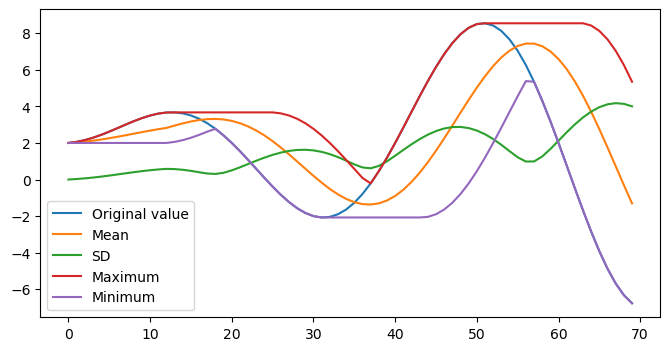

In [27]:
fig, axes = plt.subplots(figsize=(8,4))

axes.plot(feature_store['index'], feature_store['value'], label="Original value")
axes.plot(feature_store['index'], feature_store['value__mean'], label="Mean")
axes.plot(feature_store['index'], feature_store['value__standard_deviation'], label="SD")
# axes.plot(feature_store['index'], feature_store['value__variance'], label="Variance")
axes.plot(feature_store['index'], feature_store['value__maximum'], label="Maximum")
axes.plot(feature_store['index'], feature_store['value__minimum'], label="Minimum")
# axes.plot(feature_store['index'], feature_store['value__abs_energy'], label="Abs. Energy")

plt.legend()

# EOL

In [ ]:
print(flights_prepared.shape) # (144, 3)
print(extracted_features_windows.shape) # (133, 2)
display(flights_prepared.head(15))
display(extracted_features_windows[['value__length', 'value__mean', ]].head(15))


In [ ]:
print(extracted_features_windows.shape)
print(flights_prepared.shape)
print()

for i in range(0, flights_prepared.shape[0]):
    start = max(0, i - 1 - 12)
    end = i + 1
    # print(start, end)
    date_str = str(flights_prepared.iloc[i]['time']).split()[0]
    print(f"({i};{start}:{end}) - {date_str}: mean of flights = {flights_prepared.iloc[start:end]['value'].mean():.2f}, value__mean (rolled): {extracted_features_windows.iloc[i]['value__mean']:.2f}")


In [ ]:
# value__variance_larger_than_standard_deviation
# value__has_duplicate_<max;min>
# value__has_duplicate
# value__sum_values
# value__abs_energy
# value__mean_<abs_change;change;second_derivative_central>
# value__median
# value__mean
# value__length
# value__standard_deviation
# value__variation_coefficient
# value__variance
# value__skewness
# value__kurtosis
# value__root_mean_square
# value__absolute_sum_of_changes
# value__longest_strike_below_mean
# value__longest_strike_above_mean
# value__count_<above;below>_mean
# value__<last;first>_location_of_maximum
# value__<last;first>_location_of_minimum
# value__percentage_of_reoccurring_values_to_all_values
# value__percentage_of_reoccurring_datapoints_to_all_datapoints
# value__sum_of_reoccurring_<values;data_points>
# value__ratio_value_number_to_time_series_length
# value__sample_entropy
# value__maximum
# value__absolute_maximum
# value__minimum
# value__benford_correlation
# value__time_reversal_asymmetry_statistic__lag_<1;2;3>
# value__c3__lag_<1;2;3>
# value__cid_ce__normalize_<True;False>

# value__symmetry_looking__r_<0.0;0.05;0.1;0.15;0.2;0.25;0.30;0.35;0.4;0.45;0.5;0.55;0.60;0.65;0.70;0.75;0.8;0.85;0.9;0.95>
# value__large_standard_deviation__r_<0.05;0.1;0.15;0.2;0.25;0.30;0.35;0.4;0.45;0.5;0.55;0.60;0.65;0.70;0.75;0.8;0.85;0.9;0.95>
# value__quantile__q_<0.1;0.2;0.3;0.4;0.6;0.7;0.8;0.9>
# value__autocorrelation__lag_<0;1;2;3;4;5;6;7;8;9>
# value__agg_autocorrelation__f_agg_<"mean";"median";"var">__maxlag_40
# value__partial_autocorrelation__lag_<0;1;2;3;4;5;6;7;8;9>
# value__number_cwt_peaks__n_<1;5>
# value__number_peaks__n_<1;3;5;10;50>
# value__binned_entropy__max_bins_10
# value__index_mass_quantile__q_<0.1;0.2;0.3;0.4;0.6;0.7;0.8;0.9>
# value__cwt_coefficients__coeff_<0to14>__w_<2;5;10;20>__widths_(2, 5, 10, 20)
# value__spkt_welch_density__coeff_<2;5;8>
# value__ar_coefficient__coeff_<0;1;2;3;4;5;6;7;8;9;10>__k_10
# value__change_quantiles__f_agg_<"mean";"var">__isabs_<False;True>__qh_<0.2;0.4;0.6;0.8;1.0>__ql_<0.0;0.2;0.4;0.6;0.8>
# value__fft_coefficient__attr_<"real";"imag";"abs";"angle">__coeff_<0to99>
# value__fft_aggregated__aggtype_<"centroid";"variance";"skew";"kurtosis">
# value__value_count__value_<0;1;-1>
# value__range_count__max_1__min_-1
# value__range_count__max_0__min_-1000000000000.0
# value__range_count__max_1000000000000.0__min_0
# value__approximate_entropy__m_2__r_<0.1;0.3;0.5;0.7;0.9>
# value__friedrich_coefficients__coeff_<0;1;2;3>__m_3__r_30
# value__max_langevin_fixed_point__m_3__r_30
# value__linear_trend__attr_<"pvalue";"rvalue";"intercept";"slope";"stderr">
# value__agg_linear_trend__attr_<"rvalue";"intercept";"slope";"stderr">__chunk_len_<5;10;50>__f_agg_<"max";"min";"mean";"var">
# value__augmented_dickey_fuller__attr_<"teststat";"pvalue";"usedlag">__autolag_"AIC"
# value__number_crossing_m__m_<0;-1;1>
# value__energy_ratio_by_chunks__num_segments_10__segment_focus_<0to9>
# value__ratio_beyond_r_sigma__r_<0.5;1;1.5;2;2.5;3;5;6;7;10>
# value__count_<above;below>__t_0
# value__lempel_ziv_complexity__bins_<2;3;5;10;100>
# value__fourier_entropy__bins_<2;3;5;10;100>
# value__permutation_entropy__dimension_<3;4;5;6;7>__tau_1
# value__query_similarity_count__query_None__threshold_0.0
# value__matrix_profile__feature_<"min";"max";"mean";"median";"25";"75">__threshold_0.98;
# value__mean_n_absolute_max__number_of_maxima_7
